# Course project

Importing liblraries we need for data processing and visualizations

In [303]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
sns.set()

Load kaggle dataset from github

In [2]:
kaggle_ds_mult_choice = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/kaggle-survey-2018/multipleChoiceResponses.csv', low_memory=False)
kaggle_ds_mult_choice.head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,In what industry is your current employer/cont...,...,What tools and methods do you use to make your...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


Loading data with vacancies from three different sources - headhunter.com, glassdoor.com and monster.com. Data source for glassdoor.com was collected by teammate Elizaveta, oter data sources wer collected on my own. SInce all data sources has own labels and different sctructure I will need to perform some renaming and wil ltake only subsets of data.

In [270]:
monster_ds = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/Monster_job_vacancies.csv')
hh_ds_full = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/Headhunters_job_vacancies.csv')
hh_ds = hh_ds_full[['Job_Title', 'Company_Name', 'Location', 'Job_ID', 'Job_Description', 'Link', 'Compensation']]

glassdoor_ds_full = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Intro2DS/master/glassdoor.tsv', 
                          delimiter='\t',encoding='utf-8')

glassdoor_ds_full = glassdoor_ds.rename(columns={'description_text': 'Job_Description', 'url': 'Link', 
                                                    'salary': 'Compensation', 'job_title': 'Job_Title',
                                                    'company': 'Company_Name', 'location': 'Location'})

glassdoor_ds = glassdoor_ds_full[['Job_Title', 'Company_Name', 'Location', 'Job_Description', 'Link', 
                                  'Compensation']]


frames = [monster_ds, hh_ds, glassdoor_ds]
job_ds = pd.concat(frames, sort=False)
job_ds.head()

,Unnamed: 0,Job_Title,Company_Name,Location,Job_ID,Job_Description,Link,Compensation
0,0.0,Junior Data Scientist - NYC,Visionaire Partners,"Manhattan, NY 10001",213759799,\nData Scientist - NYCExciting opportunity to ...,https://job-openings.monster.com/junior-data-s...,DOE
1,1.0,Data Scientist,National Debt Relief,"New York City, NY 10038",213099686,\nWho We’re Looking For:National Debt Relief (...,https://job-openings.monster.com/data-scientis...,NaN
2,2.0,Data Scientist (NYC),Interactive Brokers LLC,"New York, NY",213764166,\nJob Description and ResponsibilitiesInteract...,https://job-openings.monster.com/data-scientis...,NaN
3,3.0,Head of Data Science Discovery,Facebook,"New York, NY",be31d872-e8b3-47dc-9033-76140bcebe27,\nCompany is a global community of more than 1...,https://job-openings.monster.com/head-of-data-...,NaN
4,4.0,Product Manager,Apex Systems,"New York, NY",213794635,\n Job Description Job #: 1016957••Please sen...,https://job-openings.monster.com/product-manag...,NaN


## Part 1 - Course curriculum design

### Processing data

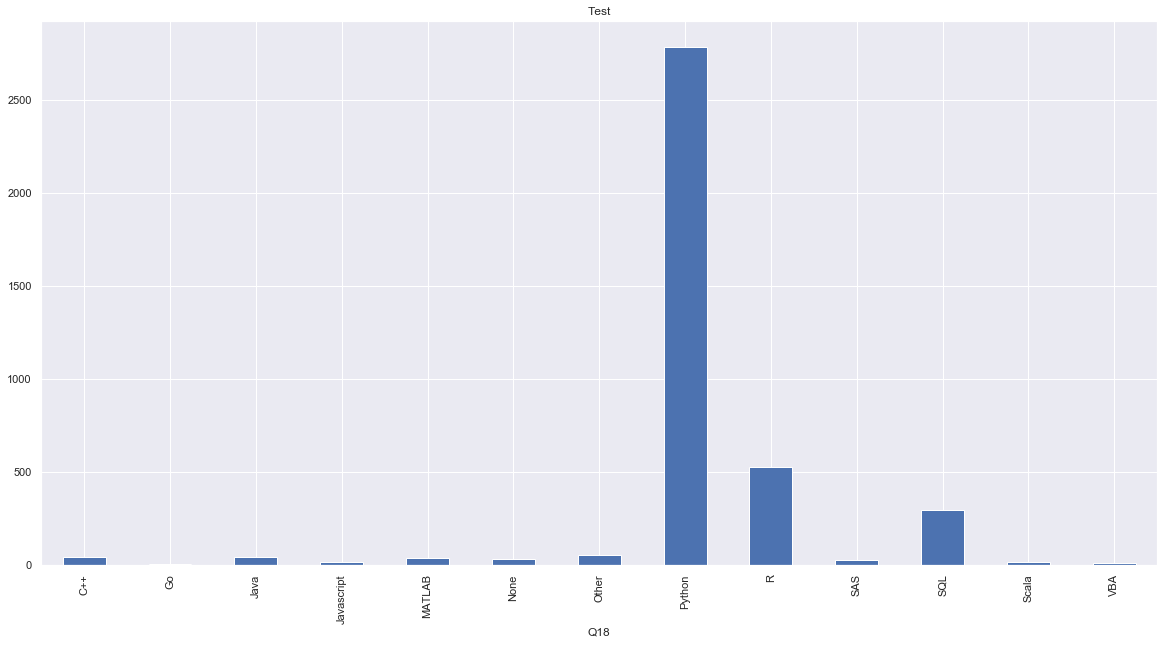

In [101]:
usa_df = kaggle_ds_mult_choice[kaggle_ds_mult_choice.Q3=='United States of America']

plt.figure(figsize=(20,10))
usa_df.groupby(by='Q18').size().plot.bar().set_title('Test')
plt.show()

Defining here some auxilary methods to be used later:
- get_skills - method used to retrieve on the fly skills from job vacancies description based on parameter with skills keywords;
- prepare_skills - method to return list of skills kewords based on topic passed. It basically contains some hardcode and used to reduce number of hardcode in other places;

In [364]:
def get_skills (source, skills):   
    result = {}
    for skill in skills:
        result[skill] = []

    for item in source:
        for skill in skills:
            if  skill == 'R ':
                if skill in item:
                    result[skill].append('1') 
                else:
                    result[skill].append('0')
            else:
                if any(term in item.lower() for term in skills[skill]):
                    result[skill].append('1') 
                else:
                    result[skill].append('0')

    return result

def prepare_skills (key):
    skills = {}
    
    if key == 'prog_lang':
        skills['Python'] = ['python']
        skills['C++'] = ['c++']
        skills['Go'] = [' go ']
        skills['Java']=['java ']
        skills['Javascript']=['javascript']
        skills['MATLAB'] = ['matlab']
        skills['R '] = ['R ']
        skills['SAS'] = ['sas']
        skills['SQL'] = ['sql']
        skills['Scala'] = ['scala']
        skills['VBA'] = ['vba']
    
    if key == 'soft_skills':
        skills['Communications'] = ['communication', 'listening', 'constructive feedback', 'friendliness', 'empathy']
        skills['Team Player'] = ['team work', 'team spirit', 'team member', 'team player', 'teamwork', 
                                 'conflict management', 'conflict handling', 'conflict resolution', 'delegation', 
                                 'collaboration', 'cooperation', 'negotiating', 'negotiation', 'idea exchange']
        skills['Adaptability'] = ['adaptability', 'curiosity', 'decision-making', 'decision making', 'optimism', 
                                 'open-mindedness', 'open mind', 'open-mind', 'self-confidence', 'self-motivation',
                                 'self confidence', 'self motivation']
        skills['Problem-Solving'] = ['problem-solving', 'problem solving', 'brainstorming', 'observation', 
                                    'persistence', 'lateral thinking']
        skills['Creativity'] = ['divergent thinking', 'imagination', 'mind mapping', 'innovation', 'experimenting',
                               'creativity']
        skills['Work Ethic'] = ['discipline', 'commitment', 'professionalism', 'responsibility', 'work ethic']
        skills['Interpersonal Skills'] = ['mentoring', 'networking', 'tolerance', 'patience', 'diplomacy']
        skills['Time Management']=['goal setting', 'prioritizing', 'prioritization', 'stress management', 'coping', 
                                  'time management', 'planning', 'planner']
        skills['Self Improvement'] = ['self-improvement', 'personal development', 'self-education', 'self improvement',
                                     'self education']
        skills['Presentation'] = ['presentation', 'public speaking']
        skills['Critical Thinking'] = ['critical thinking']
        skills['Business Understanding'] = ['business understanding', 'understand business']
        skills['Leadership'] = ['leadership', 'project management', 'selflessness', 'agility', 'cultural intelligence', 
                               'authenticity', 'trust']
        skills['People Management'] = ['people management', 'resources management', 'resource management']
        
#         skills[''] = ['']
    
    if key == 'DS_algo':
        skills['Regression'] = ['linear regression', 'logistic regression', 'jackknife regression']
#         skills['Density Estimation'] = ['density estimation']
        skills['Confidence Interval'] = ['confidence interval']
        skills['Hypotheses testing'] = ['test of hypotheses', 'hypothesis testing']
        skills['Pattern Recognition'] = ['pattern recognition']
        skills['Clustering'] = ['clustering']
        skills['Time Series'] = ['time series']
        skills['Decision Trees'] = ['decision tree']
#         skills['Random Numbers'] = ['random numbers']
        skills['Monte-Carlo Simulation'] = ['monte-carlo simulation', 'monte-carlo', 'carlo']
        skills['Bayesian Statistics'] = ['bayesian statistics', 'bayes', 'bayesian method', 'naive bayes']
        skills['PCA'] = ['principal component analysis', 'pca']
        skills['Ensembles'] = ['ensembles']
        skills['Neural Networks'] = ['neural networks', 'neural']
        skills['Supervised Learning'] = ['supervised learning', 'supervised']
        skills['SVM'] = ['support vector machine', 'support vector', 'svm']
        skills['Nearest Neighbors'] = ['nearest neighbors', 'k-nn']
        skills['Feature Selection'] = ['feature selection']
        skills['Indexation/Cataloguing'] = ['indexation', 'cataloguing']
        skills['Geo-Spatial Modeling'] = ['geo-spatial modeling', 'spatial modeling', 'geo-spatial', 'geo spatial']
        skills['Recommendation Engine'] = ['recommendation engine']
        skills['Search Engine'] = ['search engine']
        skills['Attribution Modeling'] = ['attribution modeling']
        skills['Collaborative Filtering'] = ['collaborative filtering']
#         skills['Rule System'] = ['rule system', 'rules system']
#         skills['Linkage Analysis'] = ['linkage analysis']
        skills['Association Rules'] = ['association rules']
        skills['Scoring Engine'] = ['scoring engine', 'scoring']
        skills['Segmentation'] = ['segmentation']
        skills['Predictive Modeling'] = ['predictive modeling']
        skills['Graphs'] = ['graphs', 'graph ']
        skills['Deep Learning'] = ['deep learning']
        skills['Game Theory'] = ['game theory']
        skills['Imputation'] = ['imputation']
        skills['Survival Analysis'] = ['survival analysis']
#         skills['Arbitrage'] = ['arbitrage']
        skills['Lift Modeling'] = ['lift modeling', 'lift']
        skills['Yield Optimization'] = ['yield optimization']
        skills['Cross-Validation'] = ['cross-validation', 'cross validation']
#         skills['Model Fitting'] = ['model fitting', 'fit to model', 'model fit']
        skills['Relevancy Algorithm'] = ['relevancy algorithm', 'relevancy']
        skills['Experimental Design'] = ['experimental design']
        
#         skills[''] = ['']
        
    return skills

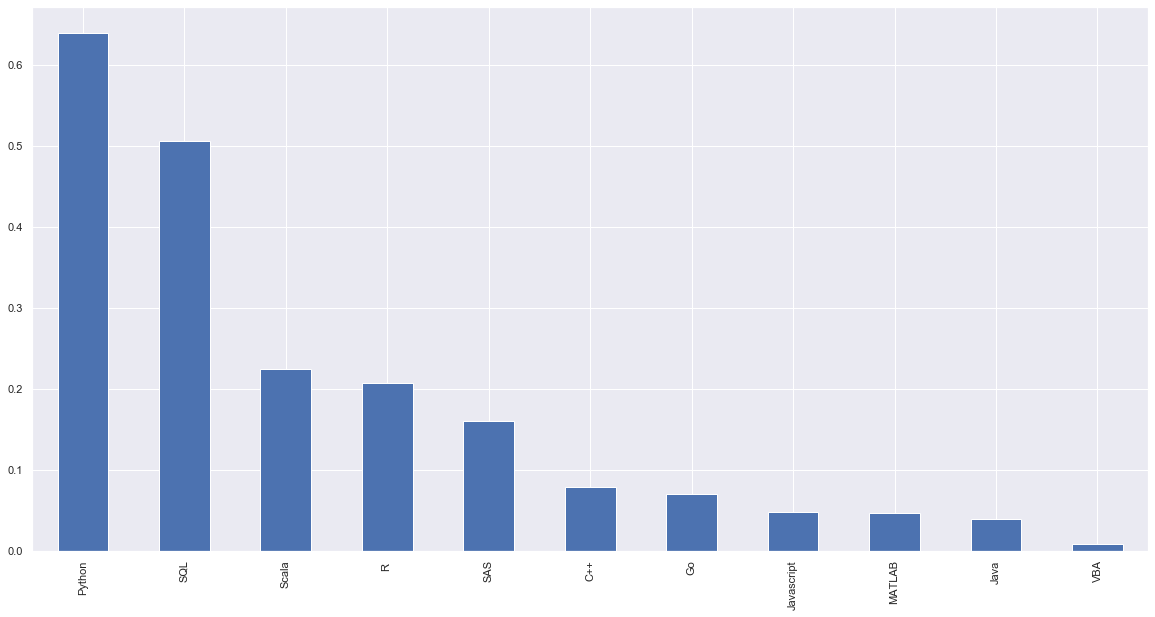

In [325]:
skills=prepare_skills('prog_lang')

res=get_skills(job_ds['Job_Description'], skills)

df = pd.DataFrame(res)

plt.figure(figsize=(20,10))
df.apply(pd.to_numeric).mean().sort_values(ascending=False).plot.bar()
plt.show()

Here I took list of Data Science methodologies and try to serach amongs all vacancies and count how many times certain methodology appears for given job offering. 

As next step I used dimple bar chart to visualize which methodologies shows up in vacancies description more often than others.

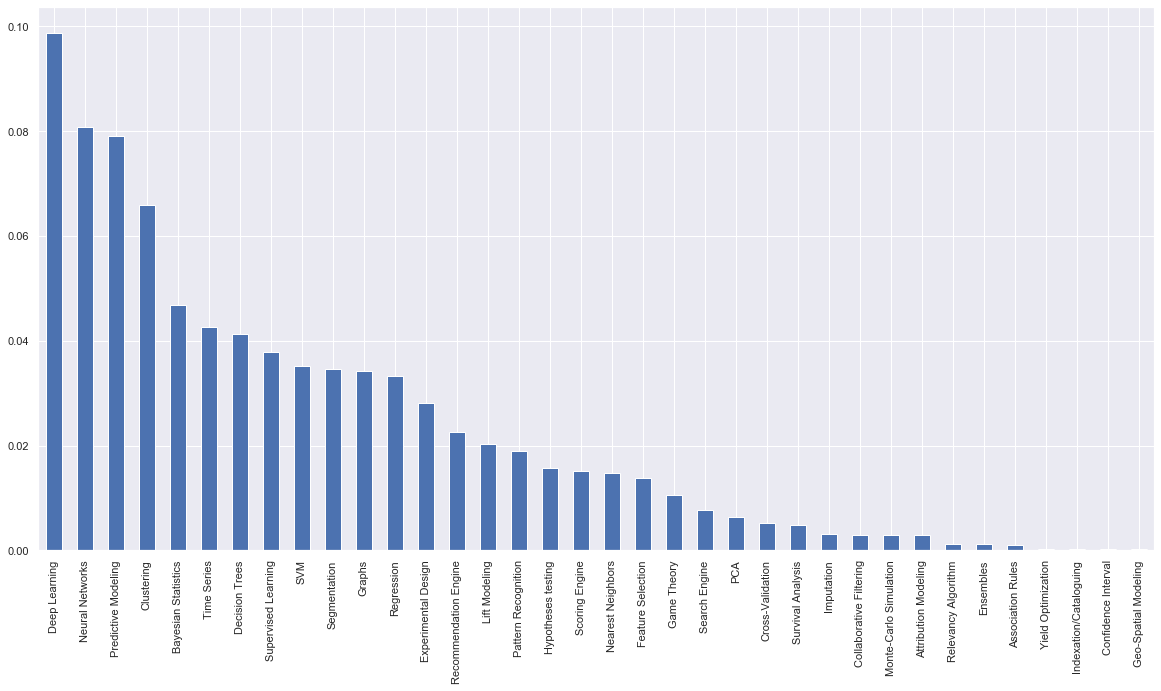

In [367]:
skills=prepare_skills('DS_algo')

res=get_skills(job_ds['Job_Description'], skills)

df = pd.DataFrame(res)

plt.figure(figsize=(20,10))
df.apply(pd.to_numeric).mean().sort_values(ascending=False).plot.bar()
plt.show()

# plt.figure(figsize=(20,10))
# X=df.apply(pd.to_numeric)
# print(X.T)
# Z=sch.linkage(X, 'ward')
# sch.dendrogram(Z, orientation='right', truncate_mode='lastp', p=22)
# plt.show()

# plt.figure(figsize=(20,10))
# cor = df.apply(pd.to_numeric).corr() #Calculate the correlation of the above variables
# sns.heatmap(cor, square = True) #Plot the correlation as heat map
# plt.show()

# plt.figure(figsize=(20,10))
# sns.clustermap(df.apply(pd.to_numeric), method="single", robust=True)
# plt.show()

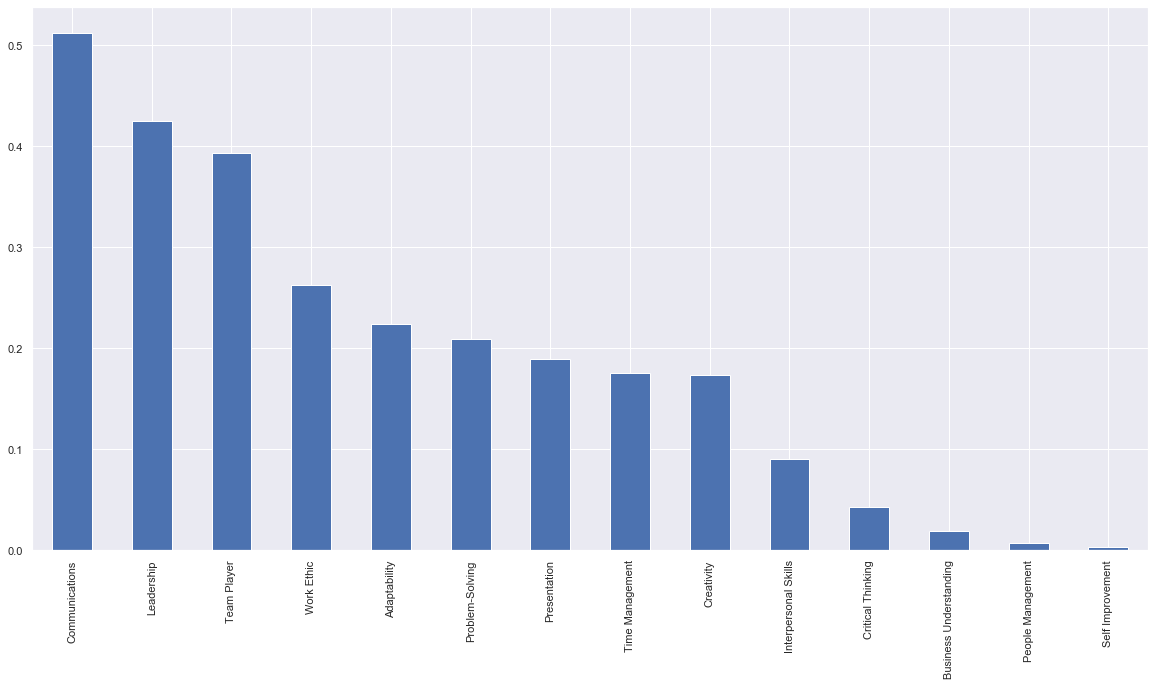

In [366]:
skills=prepare_skills('soft_skills')

res=get_skills(job_ds['Job_Description'], skills)

df = pd.DataFrame(res)

plt.figure(figsize=(20,10))
df.apply(pd.to_numeric).mean().sort_values(ascending=False).plot.bar()
plt.show()


In [186]:
# print(usa_df.groupby(by='Q18').size())

skills={}
skills['Python'] = ['python']
skills['C++'] = ['c++']
skills['Go'] = ['go']
skills['Java']=['java'] #here javascript also picked up
skills['Javascript']=['javascript']
skills['MATLAB'] = ['matlab']
skills['R '] = ['R ']
skills['Other'] = ['other']
skills['None']=['none']
skills['SAS'] = ['sas']
skills['SQL'] = ['sql']
skills['Scala'] = ['scala']
skills['VBA'] = ['vba']

res = get_skills(usa_df['Q18'].to_numpy(dtype=str), skills)

res['R '].count('1')

0